In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

from sklearn import ensemble
from sklearn import linear_model
from sklearn import model_selection
from sklearn import svm
from sklearn import metrics
from scipy import optimize

In [2]:
#Load nes data
df=pd.read_csv('/Users/emax/Documents/nes2008.csv')

#Set range of shrinkage values
l_range=[i/10000 for i in range(1,400,10)]

#Split dataframe into traiing and testing data
msk = np.random.rand(len(df)) < 0.75
df_train=df[msk]
df_test=df[~msk]

x_train=df_train[['female','age','educ','dem','rep']]
y_train=np.array(df_train[['biden']]).reshape(len(x_train),)

x_test=df_test[['female','age','educ','dem','rep']]
y_test=np.array(df_test[['biden']]).reshape(len(x_test),)

In [3]:
def get_mse_boosting(shrinkage_rate, train_f_data, train_r_data,test_f_data, test_r_data):
    '''
    A function to perform boosting with 1000 trees and given shrinkage rate
    and to return resulting training set and testing set MSEs.
    
    Inputs:
        -train_f_data: training feature data
        -train_r_data: training response data
        -test_f_data: testing feature data
        -test_r_data: testing response data
        -shrinkage_rate: lambda value (shrinkage rate)
    Returns:
        -floats: training set MSE, testing set MSE
    '''
    #Import and train gradient boosting model with 1000 trees.
    dtc=ensemble.GradientBoostingRegressor(learning_rate=shrinkage_rate,n_estimators=1000)
    dtc.fit(train_f_data,train_r_data)
    
    #Create new
    train_mse_df=pd.DataFrame({'pred':dtc.predict(train_f_data),'actual':train_r_data})
    train_mse_df['se']=train_mse_df.apply(lambda row: (row['pred']-row['actual'])**2,axis=1)
    train_mse=sum(train_mse_df['se'])/len(train_mse_df)
                                    
    test_mse_df=pd.DataFrame({'pred':dtc.predict(test_f_data),'actual':test_r_data})
    test_mse_df['se']=test_mse_df.apply(lambda row: (row['pred']-row['actual'])**2,axis=1)
    test_mse=sum(test_mse_df['se'])/len(test_mse_df)
    
    return train_mse,test_mse

#Loop over shrinkage values and record MSEs
mses=[get_mse_boosting(l,x_train,y_train,x_test,y_test) for l in l_range]
train_mses, test_mses = [mse_pair[0] for mse_pair in mses], [mse_pair[1] for mse_pair in mses]

In [4]:
#Get new shrinkage values range
new_l_range=[i/10000 for i in range(100,400,10)]
#Loop over new shrinkage values and record MSEs
new_mses=[get_mse_boosting(l,x_train,y_train,x_test,y_test) for l in new_l_range]
new_train_mses, new_test_mses = [mse_pair[0] for mse_pair in new_mses], [mse_pair[1] for mse_pair in new_mses]

Text(0, 0.5, '$\\lambda=.010,.011,\\dots$')

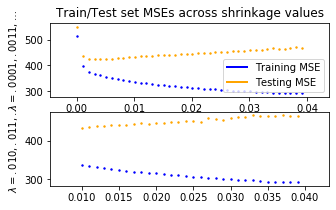

In [5]:
#Plot MSes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

plt.subplot(2, 1, 1)
plt.scatter(l_range,train_mses,color='blue',s=2)
plt.scatter(l_range,test_mses,color='orange',s=2)
custom_lines = [Line2D([0],[0], color='blue',lw=2),Line2D([0],[0], color='orange',lw=2),Line2D([0],[0], color='green',lw=2)]
plt.legend(custom_lines, ['Training MSE', 'Testing MSE'])
plt.title('Train/Test set MSEs across shrinkage values')
plt.ylabel('$\lambda=.0001,.0011,\dots$')

plt.subplot(2, 1, 2)
plt.scatter(new_l_range,new_train_mses,color='blue',s=2)
plt.scatter(new_l_range,new_test_mses,color='orange',s=2)
plt.ylabel('$\lambda=.010,.011,\dots$')

We have two histograms above: the first showing the train set and test set MSEs from boosting with shrinkage values $\lambda\in \{.0001,.0011,.0021,\dotsc,.0391\}$ and the second showing the train set and test set MSEs from boosting with shrinkage values $\lambda\in \{.010,.02-,\dotsc,.039\}$. Interestingly, train MSE values appear to decrease significantly in the range from $.0011$ to $.010$, from roughly 560 to <375. By comparison the test MSE values are fairly stable--they decrease initially and then slowly increase at (roughly) a linear rate after .005 or so. The test MSE values tend to hover in the range 375-385 for $.002\leq \lambda\.03$.

If we want to directly copmare training and testing MSE values over the ranges given, we can see that the impact of our choosing $\tilde{\lambda}=\lambda+.0001$ is negligible for larger $\lambda$ values (see below.)

Text(0, 0.5, 'Testing set MSEs')

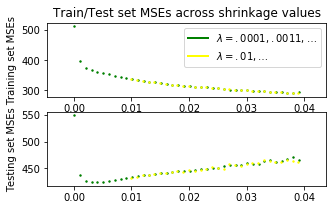

In [6]:
#Plot MSes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

plt.subplot(2, 1, 1)
plt.scatter(l_range,train_mses,color='green',s=2)
plt.scatter(new_l_range,new_train_mses,color='yellow',s=2)
plt.title('Train/Test set MSEs across shrinkage values')
custom_lines = [Line2D([0],[0], color='green',lw=2),Line2D([0],[0], color='yellow',lw=2),Line2D([0],[0], color='green',lw=2)]
plt.legend(custom_lines, ['$\lambda=.0001,.0011,\dots$', '$\lambda=.01,\dots$'])
plt.ylabel('Training set MSEs')

plt.subplot(2, 1, 2)
plt.scatter(l_range,test_mses,color='green',s=2)
plt.scatter(new_l_range,new_test_mses,color='yellow',s=2)
plt.ylabel('Testing set MSEs')

As stated, the difference of shifting our initial shrinkage values from $.0001$ to $.01$ is miniscule. More generally, we observe that as $\lambda$ increases our training error reduces continuously (albeit at a diminishing rate,) while for values $\lambda \geq .002$ or so, our testing error increases in $\lambda$ in a linear manner. This would suggest that higher $\lambda$ values lead to overfitting, since higher shrinkage values mean that more weight is given our loss function in each step of our boosting, and therefore that we force a better fit on the training data. 

So in conclusion: very small shrinkage values ($\lambda <.002$) give high training and testing MSEs (underfitting), while higher shrinkage values drive lower training MSEs and higher testing MSE (overfitting). We can therefore say that, speaking very roughly, $\lambda=.01$ is a reasonably good choice for our shrinkage value here. Of course, this is not an obvious or easy call to make; still, since from the chart above lower $\lambda$ values will decrease testing set errors only slightly, while significantly increasing training set errors, and since we know that lower shrinkage values can be very computationally expensive, it seems likely that $\lambda=.01$ is a pretty decent choice for our shrinkage value.

In [7]:
btc=ensemble.BaggingClassifier(n_estimators=1000).fit(x_train,y_train)
test_mse_df=pd.DataFrame({'pred':btc.predict(x_test),'actual':y_test})
test_mse_df['se']=test_mse_df.apply(lambda row: (row['pred']-row['actual'])**2,axis=1)
test_mse_bagging=sum(test_mse_df['se'])/len(test_mse_df)

test_mse_bagging

782.3256880733945

Using bagging with $1000$ trees, we get a testing MSE value of 782.33.

In [8]:
rdmf=ensemble.RandomForestClassifier(n_estimators=1000).fit(x_train,y_train)
test_mse_df=pd.DataFrame({'pred':rdmf.predict(x_test),'actual':y_test})
test_mse_df['se']=test_mse_df.apply(lambda row: (row['pred']-row['actual'])**2,axis=1)
test_mse_random_forrest=sum(test_mse_df['se'])/len(test_mse_df)

test_mse_random_forrest

762.4380733944954

Using random forrest with $1000$ trees, we get a testing MSE value of 762.44.

In [9]:
linreg=linear_model.LinearRegression().fit(x_train, y_train)
test_mse_df=pd.DataFrame({'pred':linreg.predict(x_test),'actual':y_test})
test_mse_df['se']=test_mse_df.apply(lambda row: (row['pred']-row['actual'])**2,axis=1)
test_mse_linear=sum(test_mse_df['se'])/len(test_mse_df)

test_mse_linear

416.0772992513134

From linear regression, we get a testing MSE value of 416.08.

In [10]:
error_table=pd.DataFrame({'Fit Type':['Boosting ($\lambda=.01$)','Bagging','Random Forrest','Linear Regression'],'Test MSE':[round(new_test_mses[0],2),round(test_mse_bagging,2),round(test_mse_random_forrest,2),round(test_mse_linear,2)]})
error_table

,Fit Type,Test MSE
0,Boosting ($\lambda=.01$),432.92
1,Bagging,782.33
2,Random Forrest,762.44
3,Linear Regression,416.08


Looking at the table above, we see that boosting with the "optimal" $\lambda$ value and linear regression give low test MSEs, while bagging and random forrest results give far higher test MSEs.

A good explanation would be overfitting. Last week, we saw that our linear model coefficients and overall MSE was consistent across choices of training/testing sets--suggesting that the linear model was actually a good fit for what was a very noisy dataset. In keeping with this, we see that boosting with a lower $\lambda$ value--though giving a slightly worse test MSE than our linear model--has also fit a reasonably robust model on our data. On the other hand,  random forrest and linear regression models put more weight on the loss function during training, i.e. these models make more significant adjustments to minimize errors against the training data. Under the hypothesis from last week that these data are very noisy, we would expect the resulting models to be overfit, having accounted for too much of the irreducible noise in our training set. In keeping with this, we see that bagging and random forrest techniques result in very high test MSE values (roughly 782,762) respectively.

In conclusion, it seems that low-$\lambda$ boosting and linear regression--by de-emphasizing and eliminiating higher-order corrections/approximations, respectively--are much better choices to get a consistent fit on a noisy dataset, compared to random forrest and bagging approaches may be useful in other contexts but in this case are very prone to overfitting.

In [11]:
df=pd.read_csv('/Users/emax/Documents/OJ.csv')
del df['Unnamed: 0']
df['Response']=df.apply(lambda row: int(row['Purchase']=='CH'), axis=1)
new_series=df.apply(lambda row: int(str(row['Store7'])=='Yes'), axis=1)
del df['Store7']
df['Store7']=new_series
del df['Purchase']

df_train, df_test = model_selection.train_test_split(df, train_size=800)

f_train=df_train[['WeekofPurchase', 'StoreID', 'PriceCH',
       'PriceMM', 'DiscCH', 'DiscMM', 'SpecialCH', 'SpecialMM', 'LoyalCH',
       'SalePriceMM', 'SalePriceCH', 'PriceDiff', 'Store7', 'PctDiscMM',
       'PctDiscCH', 'ListPriceDiff', 'STORE']]
r_train=np.array(df_train[['Response']]).reshape(len(df_train),)

f_test=df_test[['WeekofPurchase', 'StoreID', 'PriceCH',
       'PriceMM', 'DiscCH', 'DiscMM', 'SpecialCH', 'SpecialMM', 'LoyalCH',
       'SalePriceMM', 'SalePriceCH', 'PriceDiff', 'Store7', 'PctDiscMM',
       'PctDiscCH', 'ListPriceDiff', 'STORE']]
r_test=np.array(df_test[['Response']]).reshape(len(df_test),)

In [12]:
svc=svm.SVC(C=.01).fit(f_train,r_train)

#Get train error rate
r_train_pred=svc.predict(f_train)
train_error_rate=metrics.zero_one_loss(r_train_pred,r_train)

#Get test error rate
r_test_pred=svc.predict(f_test)
test_error_rate=metrics.zero_one_loss(r_test_pred, r_test)

train_error_rate,test_error_rate

(0.38125, 0.41481481481481486)

For the SVC specified above, our training error rate is .38, while our testing error rate is .41. We can see the assosciated confusion matrix below as well (recall that 1=CH, 0=MM.) In particular, the classifier we have trained misidentifies about 38-41% of our responses in both the training and testing datasets. This isn't great, but we can't say yet whether this error rate is because of our choice of SVC, or our choice of cost $C=.01$, or because of the underlying data.

Normalized confusion matrix


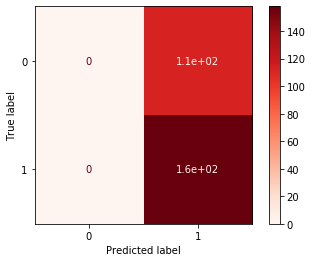

In [13]:
#Get confusion matrix
titles_options = [("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(svc, f_test, r_test,
                                 cmap=plt.cm.Reds)
    print(title)

In [14]:
def get_error_rates(c):
    '''
    With data as above, return error rates as a function of cost (c).
    '''
    svc=svm.SVC(C=c).fit(f_train,r_train)
    
    #Get train error rate
    r_train_pred=svc.predict(f_train)
    train_error_rate=metrics.zero_one_loss(r_train_pred,r_train)

    #Get test error rate
    r_test_pred=svc.predict(f_test)
    test_error_rate=metrics.zero_one_loss(r_test_pred, r_test)

    return(train_error_rate,test_error_rate)

#Error values to plot
cost_range=[i/100 for i in range(1,50000,100)]
errors=[get_error_rates(c) for c in cost_range]
train_errors, test_errors=[error[0] for error in errors], [error[1] for error in errors]

#Exact minimums
def train_err_func(c):
    return(get_error_rates(c)[0])
def test_err_func(c):
    return(get_error_rates(c)[1])

In [15]:
#Exact minimum for train error
train_err_min=optimize.minimize_scalar(train_err_func,bounds=[.01,500], method='bounded')

#Exact minimum for test error
test_err_min=optimize.minimize_scalar(test_err_func,bounds=[.01,500], method='bounded')

Text(0.5, 1.0, 'Training error rate vs. Cost')

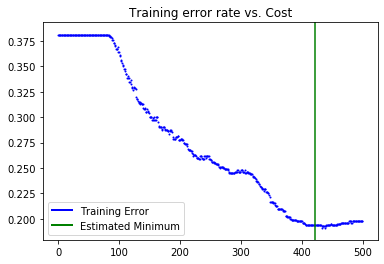

In [21]:
plt.scatter(cost_range,train_errors,color='blue',s=1)
plt.axvline(train_err_min.x, color='green')

custom_lines = [Line2D([0],[0], color='blue',lw=2),Line2D([0],[0], color='green',lw=2)]
plt.legend(custom_lines, ['Training Error','Estimated Minimum'])
plt.title('Training error rate vs. Cost')

Text(0.5, 1.0, 'Training error rate vs. Cost')

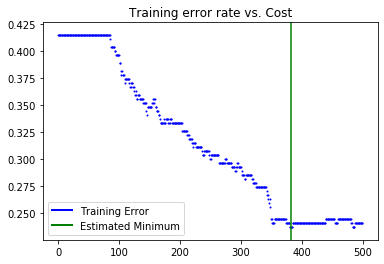

In [22]:
plt.scatter(cost_range,test_errors, color='blue',s=1)
plt.axvline(test_err_min.x, color='green')

custom_lines = [Line2D([0],[0], color='blue',lw=2),Line2D([0],[0], color='green',lw=2)]
plt.legend(custom_lines, ['Training Error','Estimated Minimum'])
plt.title('Training error rate vs. Cost')

Above, we have plotted and minimized training and testing errors against the cost $C$ used when training our SVMs. We have local minima for both testing and training MSEs when cost $C\sim 400$; this value is obviously approximate, as the graph shows, but we use it as a rough approximation to the optimal SVM cost $\tilde{C}$ below.

Normalized confusion matrix


(0.19374999999999998, 0.2407407407407407)

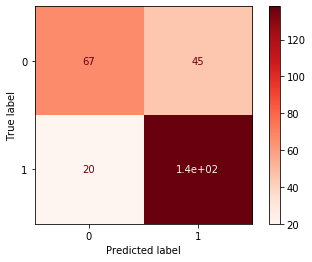

In [18]:
svc=svm.SVC(C=410).fit(f_train,r_train)

#Get train error rate
r_train_pred=svc.predict(f_train)
train_error_rate=metrics.zero_one_loss(r_train_pred,r_train)

#Get test error rate
r_test_pred=svc.predict(f_test)
test_error_rate=metrics.zero_one_loss(r_test_pred, r_test)

#Get confusion matrix
titles_options = [("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(svc, f_test, r_test,
                                 cmap=plt.cm.Reds)
    print(title)
train_error_rate,test_error_rate

The classifier with $C=410$ is a significant improvement over the classifier with $C=.01$. In particular, our error rates for training (<20%) and for testing (<25%) with the high-cost classifierare quite an improvement over the respective earlier rates (38%, 41%) from our low-cost classifier. So our new classifier certainly seems to be far better.

One thing we might want to check, however, is whether our new classifier and old classifier make the same kind of mistakes. If the new classifier is truly "tuned", we should expect that it does not introduce new mistakes that the old classifier did not (for instance, by overemphasizing a coefficient in the new model which was overlooked in the old one, with the effect that, due to correlations within the data, the emphasis on the new classification covers up the old misclassifications but introduces new misclassifications on observations that the old model got right. This would be, I suppose, a kind of overfitting, though I'm not really sure.)

This is hard to test, but one reasonable and quick sanity check for this effect would be to treat the predictions by our new classifier as our "true" values, and look at the error rate of the old classifier in predicting these outcomes. If the old classifier's error rate is higher using the fake "true" values (from the new, high-cost classifier) than with the true "true" values (as before,) we will know that we have a problem: it means our new classifier is introducing new errors in the data that the old classifier did not.

Thischeck, though far from conclusive, will help us sure up the case for this new classifier being a "tuned" version of the old one, i.e. that the new classifier makes better predictions than the old one by and large, and makes largely the same types of errors as the old one (sugesting that such errors are inherent in the noisy data and will affect any SVM classifier we train.) To my mind, this is what is meant by an optimal or tuned classifier.

In [19]:
svc=svm.SVC(C=.01).fit(f_train,r_train)
r_train_pred_new=svc.predict(f_train)
r_test_pred_new=svc.predict(f_test)

rel_train_error_rate=metrics.zero_one_loss(r_train_pred_new, r_train_pred)

rel_test_error_rate=metrics.zero_one_loss(r_test_pred_new,r_test_pred)
rel_train_error_rate, rel_test_error_rate

(0.31000000000000005, 0.3222222222222222)

As we had hoped, the old predictor does better against these data than it had originally, with its training error rate declining from 38% to 31% and its testing error rate declining 41% to 32% when we use the new data.

This gives at least some weight to the hypothesis that the errors the new classifier is making are similar to the errors the old classifier was making, which in turns gives some weight to the hypothesisthat the new calssifier is pretty well tuned, up to some errors inherent to our data set/to the limitations of SVM. We can't go so far as to say that, and we can't say that our model is "the" tuned and optimal model (clearly, our choice of a high cost $C=410$ was quite rough, and looking at our plots of training/testing errors above it seems that higher costs for $C$ may produce SVMs that perform even better.) Still, we can say that it's a good deal better tuned than our original classification model with $C=.01$.